In [10]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.recurrent import LSTM
from keras.backend import squeeze
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from data_loader import *
from inception import *
import tensorflow as tf
from keras.utils import multi_gpu_model, plot_model

In [2]:
x_train, y_train, x_val, y_val = get_data(mode='time_series',
                                          load_mods=['CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB', 'GFSK_5KHz'],
                                         BASEDIR='../Data/training_data/',
                                         files=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_WB
[Data Loader] - [Modulation Dataset] Adding Collects for: GFSK_5KHz
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 54000 Validation Size: 6000 Test Size: 0
[Data Loader] - Done.

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Datase

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_WB
[Data Loader] - [Modulation Dataset] Adding Collects for: GFSK_5KHz
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 54000 Validation Size: 6000 Test Size: 0
[Data Loader] - Done.

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Datase

In [11]:
model_9 = {'depths': np.array([2, 2, 1, 0, 0, 2, 1]), 'features': np.array([3, 2, 3, 3, 3, 3, 3, 3]), 'dr': 0.67561133072930946}
input_img = Input(shape=(1024,2))
out = googleNet(input_img,data_format='channels_last', pdict=model_9, num_classes=5)
model = Model(inputs=input_img, outputs=out)


In [7]:
def inception(input_img, fs=[64,64,64,64,64], with_residual=False):
    tower_1 = Conv2D(filters=fs[0], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size=8, padding='same', activation='relu')(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size=4, padding='same', activation='relu')(tower_3)
    tower_5 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(filters=fs[3], kernel_size=2, padding='same', activation='relu')(tower_5)
    tower_4 = MaxPooling2D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same', activation='relu')(tower_4)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4, tower_5], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_last'):
#     num_layers = [2,4,10,4]
    num_layers = [1,2,2,1]
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 64, kernel_size=[2,7], strides=[2,2], data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 192, kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu')(x)
    x = MaxPooling2D([1,3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, fs=[32,64,32,64,64])
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
        x = inception(x, fs=[48,96,48,96,96], with_residual=True)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x, fs=[32,64,32,64,64])
#     x = GlobalAveragePooling1D()(x)
#     x = Conv2D(filters=64, kernel_size=[1,1], padding='same', activation='relu')(x) # optional dim reduction

    x = Dropout(0.4)(x)
    output = Flatten()(x)
    out    = Dense(5, activation='softmax')(output)
    return out
in_shp = (1024, 2)
input_img = Input(shape=in_shp)
out = googleNet(input_img,data_format='channels_last')
model = Model(inputs=input_img, outputs=out)

In [12]:
model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
#print('model compiled')
model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 756000 samples, validate on 84000 samples
Epoch 1/50
756000/756000 [==============================] - 419s 554us/step - loss: 0.7791 - acc: 0.6714 - val_loss: 0.6193 - val_acc: 0.7400
Epoch 2/50
756000/756000 [==============================] - 417s 551us/step - loss: 0.4850 - acc: 0.8017 - val_loss: 0.7221 - val_acc: 0.7462
Epoch 3/50
756000/756000 [==============================] - 417s 551us/step - loss: 0.3462 - acc: 0.8626 - val_loss: 0.8566 - val_acc: 0.7537
Epoch 4/50
756000/756000 [==============================] - 416s 551us/step - loss: 0.2435 - acc: 0.9076 - val_loss: 0.9827 - val_acc: 0.7592
Epoch 5/50
756000/756000 [==============================] - 415s 549us/step - loss: 0.1851 - acc: 0.9330 - val_loss: 0.9761 - val_acc: 0.7737
Epoch 6/50
756000/756000 [==============================] - 415s 549us/step - loss: 0.1506 - acc: 0.9476 - val_loss: 1.3484 - val_acc: 0.7763
Epoch 7/50
756000/756000 [==============================] - 414s 548us/step - loss: 0.1346 - acc:

KeyboardInterrupt: 

In [20]:
test_file = "../Data/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(test_file, 0, 0, 1., load_mods=['CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB', 'GFSK_5KHz'])

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_WB
[Data Loader] - [Modulation Dataset] Adding Collects for: GFSK_5KHz
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 0 Validation Size: 0 Test Size: 60000
[Data Loader] - Done.



In [19]:
target_mods = test_data.modTypes[9:14]
target_mods

array(['CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB', 'GFSK_5KHz'],
      dtype='<U11')

In [3]:
number_of_samples_in_instance = data.instance_shape[1]
data.modTypes

array(['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB',
       'APSK16_c34', 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz',
       'FM_NB', 'FM_WB', 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE',
       'OQPSK', 'PI4QPSK', 'QAM16', 'QAM32', 'QAM64', 'QPSK'],
      dtype='<U11')

In [14]:
# for each modulation type, inspect some instances of data
for modType in data.modTypes[:]:
    min_SNR = -10
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    print(cdata.shape,index)

    # setup inspect
    sample_rate = number_of_samples_in_instance
    Ts = 1.0 / sample_rate
    t = np.arange(0, len(cdata[0])) * Ts
    
    plt.figure()
    plt.title(modType)
    plt.plot(cdata.squeeze().real)
    plt.plot(cdata.squeeze().imag)
    # inspect signal
plt.show()
    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

NameError: name 'data' is not defined

Using TensorFlow backend.


In [3]:
in_shp = [2,1024]
dr = 0.5 # dropout rate (%)
classes = data.modTypes
with tf.device("/cpu:0"):
    model = models.Sequential()
    model.add(Reshape(in_shp+[1], input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(256, kernel_size=(1, 5), strides=(1,2), border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(80, kernel_size=(2, 3), border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    rshape = model.output_shape
    print(model.output_shape)
    model.add(Reshape([rshape[2],rshape[3]]))
    model.add(LSTM(64, return_sequences=True, name='lstm1'))
    model.add(LSTM(64, return_sequences=True, name='lstm2'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.summary()
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')

    

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(1, 5), strides=(1, 2), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform")`
  
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, kernel_size=(2, 3), activation="relu", name="conv2", padding="valid", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()


(None, 1, 514, 80)


/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, name="dense2", kernel_initializer="he_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 1024, 1)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 1028, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 512, 256)       1536      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 512, 256)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 516, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 514, 80)        122960    
_________________________________________________________________
reshape_2 (Reshape)          (None, 514, 80)           0         
__________

In [4]:
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
train_batch_size, number_of_epochs = 256, 10
tsteps = data.train_idx.size/train_batch_size
vsteps = data.val_idx.size/train_batch_size
train_batches = data.batch_iter(data.train_idx, train_batch_size, number_of_epochs, use_shuffle=True)
val_batches = data.batch_iter(data.val_idx, train_batch_size, number_of_epochs, use_shuffle=False)

history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# # we re-load the best weights once training is finished
# model.load_weights(filepath)

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1012.5, verbose=2, validation_data=<generator..., validation_steps=112.5, callbacks=[<keras.ca..., epochs=10)`
  app.launch_new_instance()


Epoch 1/10


KeyboardInterrupt: 

NameError: name 'history' is not defined

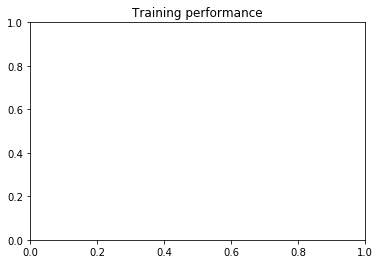

In [13]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_file = "../Data/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(test_file, 0., 0., 1.)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [15]:
# Plot confusion matrix# Plot c 
data_file = "training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(data_file, .0, .0, 1.)
X_test = testdata.signalData[data.test_idx]
Y_test = testdata.oneHotLabels[data.test_idx]
test_Y_hat = model.predict(X_test, batch_size=train_batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(14,14))
plot_confusion_matrix(confnorm, labels=classes)

[Data Loader] - Loading Data...


FileNotFoundError: [Errno 2] No such file or directory: '/home/mshefa/training_data/training_data_chunk_14.pkl'

SNR -15 Overall Accuracy:  0.5366 Out of 10000
SNR -10 Overall Accuracy:  0.582 Out of 20000
SNR -5 Overall Accuracy:  0.7193 Out of 10000
SNR 0 Overall Accuracy:  0.7132 Out of 10000
SNR 5 Overall Accuracy:  0.73805 Out of 20000
SNR 10 Overall Accuracy:  0.8259 Out of 10000


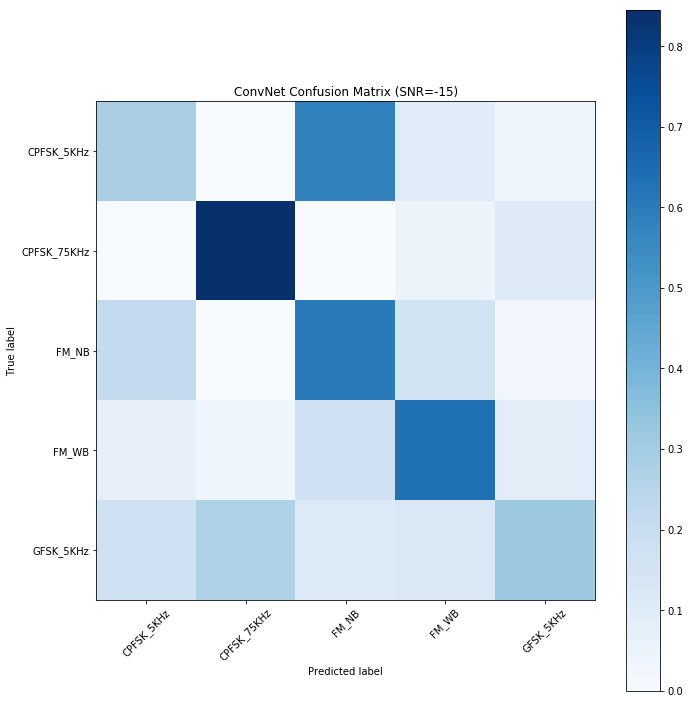

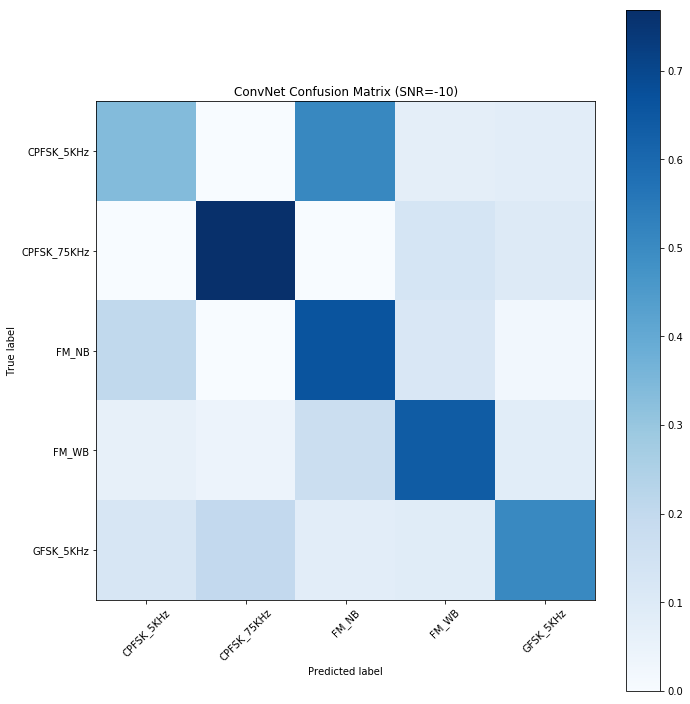

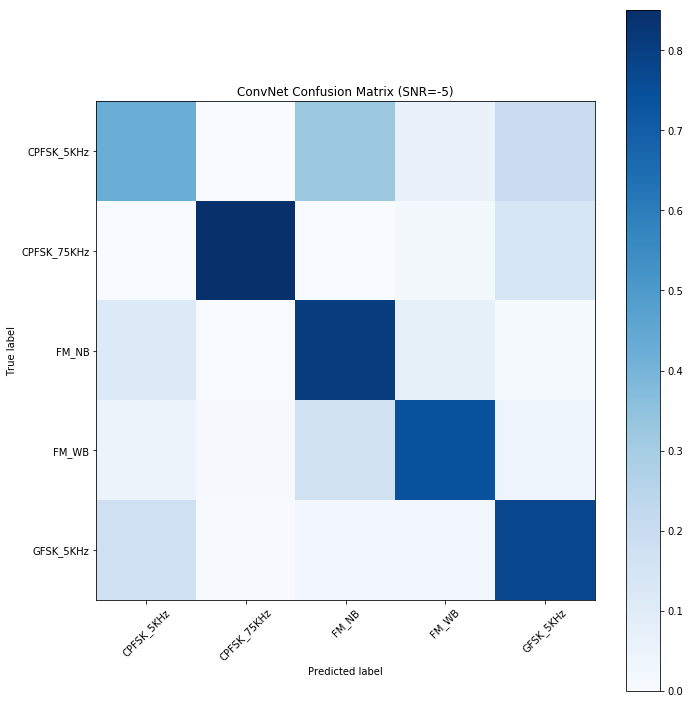

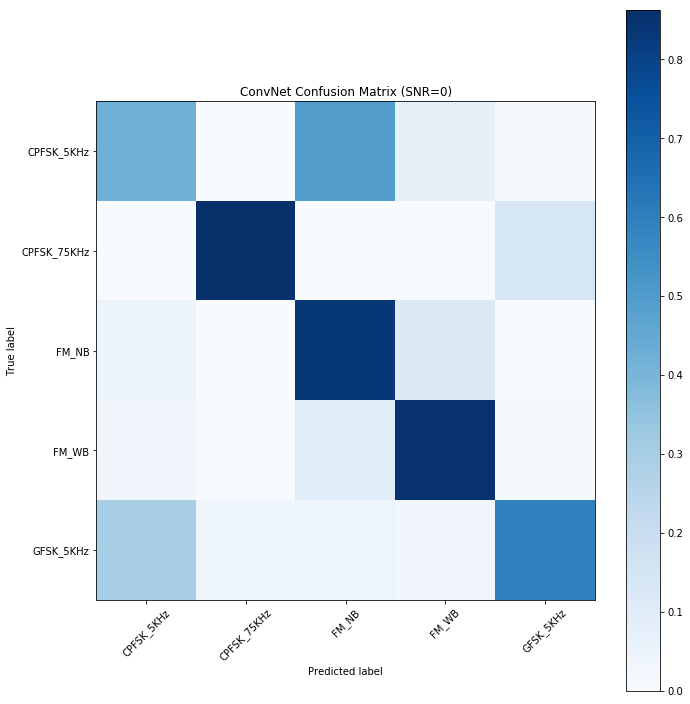

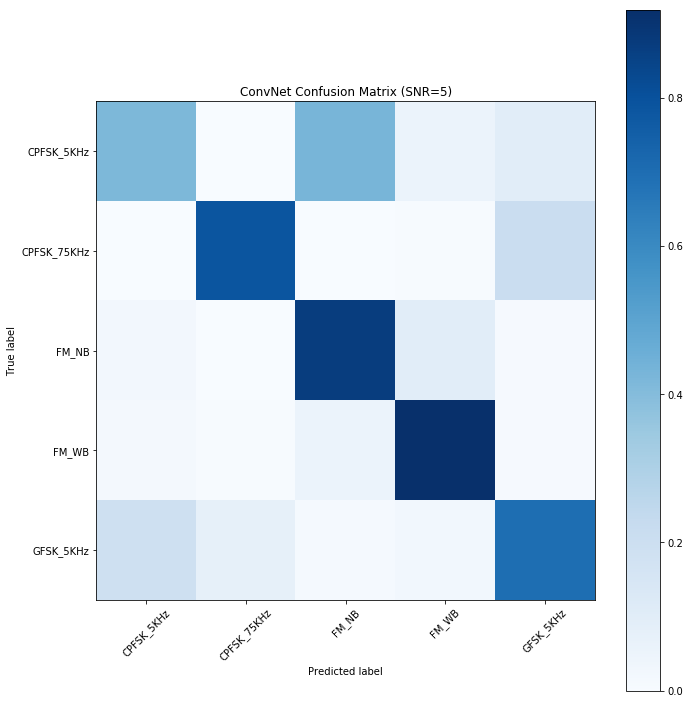

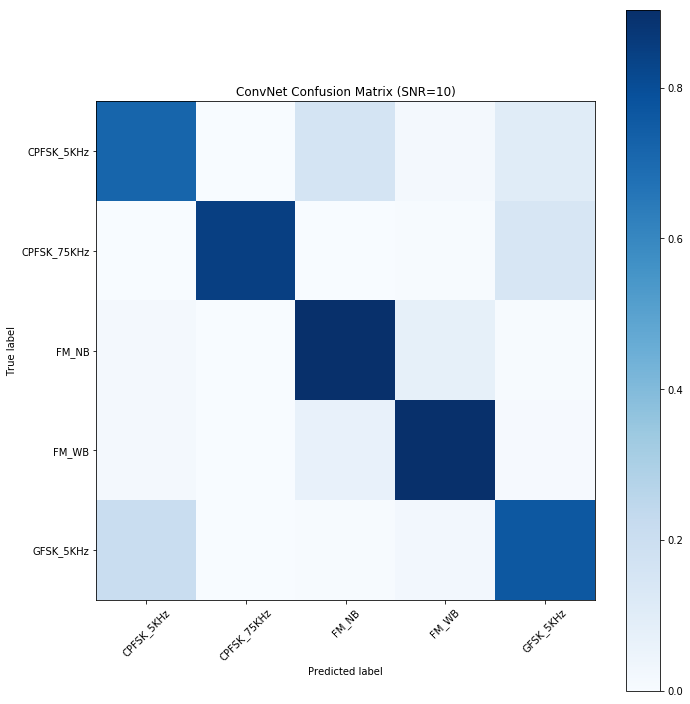

In [21]:

# Plot confusion matrix
acc = {}
snrs = np.arange(-15,15, 5)
classes = testdata.modTypes
for snr in snrs:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(testdata.test_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_X_i = np.transpose(test_X_i, (0,2,1))
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)

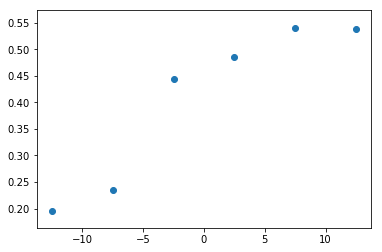

In [38]:
plt.scatter(np.array(list(acc.keys()))+2.5, list(acc.values()))

In [37]:
acc

{-15: 0.19625,
 -10: 0.23449571935685948,
 -5: 0.4435517970401691,
 0: 0.4856909239574816,
 5: 0.540625,
 10: 0.5371308016877637}

In [43]:
from keras.layers.recurrent import 

In [80]:
def get_params(size=10):
    
    f1, f2, f3, stride1, kernel1 = [], [], [], [], []
    for i in range(size):
        f1.append(random.randint(5,10))
        f2.append(random.randint(5, f1[-1]))
        f3.append(random.randint(5, 8))
        if np.random.random() > 0.5:
            s1 = (1,2)
        else:
            s1 = (1,1)
        if np.random.random() > 0.5:
            k1 = (1,5)
        else:
            k1 = (1,3)
        stride1.append(s1)
        kernel1.append(k1)
    f1 = 2**np.asarray(f1)
    f2 = 2**np.asarray(f2)
    f3 = 2**np.asarray(f3)
    return f1, f2, f3, stride1, kernel1
print(get_params(10))

def build_model(f1, f2, f3, kernel1, stride1, dr=0.5, in_shp=[2,1024]):
    model = models.Sequential()
    model.add(Reshape(in_shp+[1], input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(f1, kernel_size=kernel1, strides=stride1, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(f2, kernel_size=(2,3), border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(f3, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.summary()
    return model

(array([ 128, 1024, 1024, 1024, 1024,  256,   32, 1024,  128,  128]), array([ 64, 512, 256, 128,  32,  32,  32, 512,  32,  32]), array([128, 256,  32,  32, 128,  32, 128, 128, 128,  32]), [(1, 2), (1, 1), (1, 2), (1, 1), (1, 2), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1)], [(1, 3), (1, 3), (1, 5), (1, 3), (1, 5), (1, 3), (1, 5), (1, 3), (1, 3), (1, 3)])


In [13]:
from keras.layers import Layer
from keras import backend as K
from keras.engine.base_layer import InputSpec
class _GlobalPooling1D(Layer):
    """Abstract class for different global pooling 1D layers.
    """

    def __init__(self, **kwargs):
        super(_GlobalPooling1D, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

    def call(self, inputs):
        raise NotImplementedError
class GlobalAveragePooling1D(_GlobalPooling1D):
    """Global average pooling operation for temporal data.
    # Input shape
        3D tensor with shape: `(batch_size, steps, features)`.
    # Output shape
        2D tensor with shape:
        `(batch_size, features)`
    """

    def call(self, inputs, keepdims=True):
        return K.mean(inputs, axis=1, keepdims=keepdims)

## 1D Inception

In [14]:
from keras.layers import Input

from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras import backend as K 

def inception(input_img, fs=[64,64,64,64,64], with_residual=False):
    tower_1 = Conv1D(fs[0], 1, padding='same', activation='relu')(input_img)
    tower_1 = Conv1D(fs[1], 3, padding='same', activation='relu')(tower_1)
    tower_2 = Conv1D(fs[2], 1, padding='same', activation='relu')(input_img)
    tower_2 = Conv1D(fs[3], 5, padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling1D(3, strides=1, padding='same')(input_img)
    tower_3 = Conv1D(fs[4], 1, padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 2)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_last'):
    x = Conv1D(64, 7, strides=2, data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(2):
        x = Conv1D(192, 3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(4):
        x = inception(x, fs=[32,64,32,64,64])
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(10):
        x = inception(x, fs=[48,96,48,96,96], with_residual=True)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(4):
        x = inception(x, fs=[32,64,32,64,64])
    x = GlobalAveragePooling1D()(x, keepdims=True)
    x = Dropout(0.4)(x)
    output = Flatten()(x)
    out    = Dense(24, activation='softmax')(output)
    return out

input_img = Input(shape=(1024,2))
out = googleNet(input_img,data_format='channels_last')
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1024, 2)      0                                            
__________________________________________________________________________________________________
conv1d_280 (Conv1D)             (None, 512, 64)      960         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_67 (MaxPooling1D) (None, 256, 64)      0           conv1d_280[0][0]                 
__________________________________________________________________________________________________
conv1d_281 (Conv1D)             (None, 256, 192)     37056       max_pooling1d_67[0][0]           
__________________________________________________________________________________________________
conv1d_282

In [15]:
def get_data(data_format='channel_last'):
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    BASEDIR = "/home/mshefa/training_data/"
    data_file = BASEDIR+"training_data_chunk_0.pkl"
    data = LoadModRecData(data_file, .9, .1, 0.)
    
    x_train = data.signalData[data.train_idx]
    y_train = data.oneHotLabels[data.train_idx] 
    x_val = data.signalData[data.val_idx]
    y_val = data.oneHotLabels[data.val_idx]
    if data_format == "channel_last":
        x_train = np.transpose(x_train, (0,2,1))
        x_val = np.transpose(x_val, (0,2,1))

    return x_train, y_train, x_val, y_val
x_train, y_train, x_val, y_val =get_data()

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [18]:
filepath = './basemodels/inception.wts.h5'
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')
train_batch_size, number_of_epochs = 512, 10
history = model.fit(x_train, y_train,
          batch_size=train_batch_size,
          epochs=20,
          verbose=2,
          validation_data=(x_val, y_val),
          callbacks = [
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
          ])
score, acc = model.evaluate(x_val, y_val, verbose=0)
print('Test accuracy:', acc)

Train on 259200 samples, validate on 28800 samples
Epoch 1/20
 - 169s - loss: 2.2988 - val_loss: 1.8220
Epoch 2/20
 - 139s - loss: 1.7432 - val_loss: 1.5956
Epoch 3/20
 - 140s - loss: 1.5103 - val_loss: 1.4232
Epoch 4/20
 - 139s - loss: 1.3528 - val_loss: 1.2565
Epoch 5/20
 - 138s - loss: 1.2514 - val_loss: 1.1709
Epoch 6/20
 - 140s - loss: 1.1933 - val_loss: 1.1315
Epoch 7/20
 - 139s - loss: 1.1452 - val_loss: 1.1222
Epoch 8/20
 - 141s - loss: 1.1102 - val_loss: 1.0770
Epoch 9/20
 - 140s - loss: 1.0796 - val_loss: 1.0471
Epoch 10/20
 - 139s - loss: 1.0506 - val_loss: 1.0549
Epoch 11/20
 - 139s - loss: 1.0350 - val_loss: 1.0301
Epoch 12/20
 - 142s - loss: 1.0121 - val_loss: 1.0604
Epoch 13/20
 - 143s - loss: 0.9870 - val_loss: 0.9845
Epoch 14/20
 - 141s - loss: 0.9684 - val_loss: 0.9593
Epoch 15/20
 - 142s - loss: 0.9582 - val_loss: 0.9673
Epoch 16/20
 - 143s - loss: 0.9385 - val_loss: 1.0027
Epoch 17/20
 - 140s - loss: 0.9264 - val_loss: 1.0692
Epoch 18/20
 - 144s - loss: 0.9132 - val

TypeError: 'numpy.float64' object is not iterable

## 2D resnet

In [2]:
from resnet2D import ResnetBuilder
from custom_layers import get_data
img_train, y_train, img_val, y_val = get_data(mode='fourier')
img_train = img_train[:,:,16:48,:]
img_val = img_val[:,:,16:48,:]

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [3]:
from resnet2D import ResnetBuilder
img_channels, img_rows, img_cols = 2, 16, 32
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), 24)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 32, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 32, 64)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')
hist = model.fit(img_train, y_train,
          batch_size=256,
          nb_epoch=20,
          validation_data=(img_val, y_val),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, csv_logger])

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 259200 samples, validate on 28800 samples
Epoch 1/20
259200/259200 [==============================] - 138s 531us/step - loss: 3.4134 - acc: 0.0414 - val_loss: 3.2158 - val_acc: 0.0399
Epoch 2/20
 79104/259200 [========>.....................] - ETA: 1:27 - loss: 3.2076 - acc: 0.0429

In [5]:
img_val.shape

(28800, 16, 64, 2)

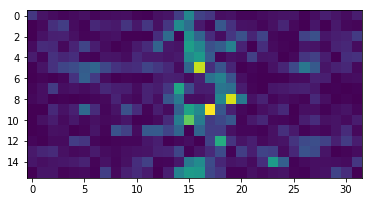

In [16]:
a = img_val[6]
a = a[...,0]**2+a[...,1]**2
a = a[:,16:48]
plt.imshow(a)

# Hyperparameter search

In [12]:
from multiprocessing import Process, Queue, Event
import multiprocessing as mp
import numpy as np
from time import sleep
from inception import *

class TrainWorker(Process):
    def __init__(self, data, task_q: Queue, result_q, stop_event: Event, name):
        super().__init__()
        self.task_q = task_q
        self.result_q = result_q
        self.stop_event = stop_event
        self.name = name
        self.x_train, self.y_train, self.x_test, self.y_test = data

    def train_model(self, theta, k, resource):
        import keras
        from keras.datasets import mnist
        from keras.models import Sequential
        from keras.layers import Dense, Dropout, Flatten
        from keras.layers import Conv2D, MaxPooling2D
        from keras import backend as K
        import tensorflow as tf
        import numpy as np
        import os
        from inception import googleNet, get_pdict
        
        
        batch_size = 128
        num_classes = 24
        epochs = int(resource)
        
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
        os.environ["CUDA_VISIBLE_DEVICES"] = str(self.name)
        print("starting on", self.name, 'rung', k, 'epochs', epochs)
        
        input_img = Input(shape=(1024,2))
        out = googleNet(input_img,data_format='channels_last', pdict=theta)
        model = Model(inputs=input_img, outputs=out)
        model.summary()
        
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        #print('model compiled')
        model.fit(self.x_train, self.y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(self.x_test, self.y_test))
        score = model.evaluate(self.x_test, self.y_test, verbose=0)
        return score

    def run(self):
        while not self.stop_event.is_set():
            if self.task_q.empty():
                sleep(0.1)
            else:
                #print("Received task", self.name)
                idx, theta, k, resource = self.task_q.get()
                score = self.train_model(theta, k, resource)
                print('putting result', (idx, theta, k))
                self.result_q.put((idx, theta, k, score[0]))
                
class JobManager(Process):
    def __init__(self, train_worker, task_q: Queue, result_q: Queue, ladder, stop_event: Event):
        super().__init__()
        self.train_worker = train_worker
        self.result_q = result_q
        self.task_q = task_q
        self.ladder = ladder
        self.stop_event = stop_event
        self.eta = 3
        self.KMAX = 4
        self.resource_min = 1
        self.bracket = 0
        self.idx = 0
        while not self.task_q.full():
            theta = get_pdict(mode='orig')
            theta['dr'] = np.random.uniform(0.35, 0.65, size=1)[0]
            self.task_q.put((self.idx, theta, 0,self.resource_min*self.eta**(0+self.bracket)))
            self.update_ladder(k=0)
            self.idx += 1
            
    def update_ladder(self, k, idx=None, value=None):
        if idx is None:
            idx = self.idx
        if len(self.ladder) <= k:
            self.ladder.append({})
        self.ladder[k][idx] = value

    def get_job(self):
        kmax = len(self.ladder)-1
        job = None
        if kmax> self.KMAX:
            self.stop_event.set()
            print("stopping event")
        for k in range(kmax+1)[::-1]:
            rung = self.ladder[k]  #dictionary{idx:(theta, loss), idx2:None}
            rung = [(key, val) for key, val in rung.items() if val is not None]
            if len(rung) < self.eta: continue
            rung = sorted(rung, key=lambda x:x[1][1])
            promotable = rung[:int(float(len(rung))/self.eta)]
            if k == kmax:
                best = promotable[0]
            else:
                best = None
                for p in promotable:
                    if p[0] not in list(self.ladder[k+1].keys()):
                        best = p
                        break
            if best is not None:
                job = (best[0], best[1][0], k+1)
                break
        
        if job is None:
            job = (self.idx, get_pdict(mode='prior'), 0)
            self.idx += 1
        print("submit job", job)
        
        return job
    
    def run(self):
        while not self.stop_event.is_set():
            if self.result_q.empty():
                sleep(1)
            else:
                idx, theta, k, loss = self.result_q.get()
                print('Received result', idx, k, loss)
                self.update_ladder(k, idx=idx, value=(theta, loss))
                idx, theta, k = self.get_job()
                self.update_ladder(k, idx=idx)
#                 print("### Updating Ladder ###")
#                 for k, rung_dict in enumerate(self.ladder):
#                     print("Rung#", k, rung_dict)
                resource = self.resource_min*self.eta**(k+self.bracket)
                self.task_q.put((idx, theta, k, resource))
                

class async_SHA:
    def __init__(self, data):
        self.stop_event = Event()
        self.result_q = Queue(4)
        self.ladder = []
        self.task_q = Queue(2)
        
    def run(self):
        self.train_worker = {pid: TrainWorker(data, self.task_q, self.result_q, self.stop_event, name=str(pid)) for pid in range(2)}
        for w in self.train_worker.values():
            w.start()
        self.job_manager = JobManager(self.train_worker, self.task_q, self.result_q, self.ladder, self.stop_event)
        self.job_manager.start()
        if self.stop_event.is_set():
            print(self.ladder)
            for w in self.train_worker.values():
                w.join()
                #w.terminate()
            self.job_manager.join()
            #self.job_manager.terminate()

In [10]:
x_train, y_train, x_val, y_val = get_data(mode='time_series',
                                         BASEDIR="/home/mshefa/training_data/",
                                         files=[0])
data = (x_train, y_train, x_val, y_val)


[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [13]:
a = async_SHA(data)
a.run()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` insteadWARNING:tensorflow:From /home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 2)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 64)      960         input_1[0][0]                    
_________________________________________________________________________________

conv1d_15 (Conv1D)              (None, 128, 96)      18528       conv1d_14[0][0]                  
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 128, 48)      7728        conv1d_16[0][0]                  
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 128, 64)      8256        max_pooling1d_5[0][0]            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 128, 208)     0           conv1d_15[0][0]                  
                                                                 conv1d_17[0][0]                  
                                                                 conv1d_18[0][0]                  
conv1d_7 (Conv1D)               (None, 128, 32)      2592        conv1d_6[0][0]                   
__________

                                                                 conv1d_13[0][0]                  
__________________________________________________________________________________________________
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 128, 64)      8256        concatenate_2[0][0]              
conv1d_36 (Conv1D)              (None, 64, 16)       3856        concatenate_6[0][0]              
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 128, 32)      4128        concatenate_2[0][0]              
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 128, 128)     0           concatenate_2[0][0]              
__________________________________________________________________________________________________
conv1d_15 

__________________________________________________________________________________________________
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 64, 64)       15424       concatenate_8[0][0]              
conv1d_31 (Conv1D)              (None, 64, 16)       3856        concatenate_5[0][0]              
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 64, 32)       7712        concatenate_8[0][0]              
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 64, 240)      0           concatenate_8[0][0]              
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 64, 128)      24704       conv1d_44[0][0]                  
__________

conv1d_58 (Conv1D)              (None, 32, 64)       18496       max_pooling1d_15[0][0]           
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 32, 192)      0           conv1d_55[0][0]                  
                                                                 conv1d_57[0][0]                  
                                                                 conv1d_58[0][0]                  
__________________________________________________________________________________________________
conv1d_59 (Conv1D)              (None, 32, 32)       6176        concatenate_11[0][0]             
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 32, 32)       6176        concatenate_11[0][0]             
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 32, 64)       18496       max_pooling1d_15[0][0]           
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 32, 192)      0           conv1d_55[0][0]                  
                                                                 conv1d_57[0][0]                  
                                                                 conv1d_58[0][0]                  
__________________________________________________________________________________________________
conv1d_59 (Conv1D)              (None, 32, 32)       6176        concatenate_11[0][0]             
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 32, 32)       6176        concatenate_11[0][0]             
__________

Process JobManager-12:
Traceback (most recent call last):
  File "/home/yunfanz/miniconda3/envs/seti/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-12-bd645bb7ae12>", line 131, in run
    idx, theta, k = self.get_job()
  File "<ipython-input-12-bd645bb7ae12>", line 117, in get_job
    job = (self.idx, get_dict(mode='prior'), 0)
NameError: name 'get_dict' is not defined


putting result (1, {'depths': array([2, 2, 2, 2, 2, 2, 2]), 'features': array([2, 2, 2, 2, 2, 2, 2, 2]), 'dr': 0.44184539412583396}, 0)


Process 1:
Traceback (most recent call last):
  File "/home/yunfanz/miniconda3/envs/seti/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-12-bd645bb7ae12>", line 57, in run
    sleep(0.1)
Process 0:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/yunfanz/miniconda3/envs/seti/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-12-bd645bb7ae12>", line 57, in run
    sleep(0.1)
KeyboardInterrupt
